# Iterations

решение уравнений методом последовательных итераций.

Постановка задачи:
Известно решение (M-model) для некоторой эпохи, сделан расчет содержания водорода на новую эпоху,
надо найти решение для новой эпохи, в предположении что решение изменилось не сильно.

In [18]:
import math
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

In [19]:
import NotebookLoader
import Physics as ph
import SSM18 as s

In [20]:
pi = math.pi
Z = s.Z

In [34]:
def load_model(epoch):
    filename = 'Mass/4epoch%.02d.csv' % epoch
    return pd.read_csv(filename)

In [86]:
# Загружаем известное решение (M-model)
epoch = 0
df = load_model(epoch)
dimM = len(df.index)
df

,Unnamed: 0,Mass,Radius,Temperature,Density,Luminosity,Hydrogen,Opacity,Convection,Pressure,Velocity
0,0,0.000000e+00,0.000000e+00,1.451000e+07,90.073860,0.000000e+00,0.732,1.445415,0.0,1.794120e+17,1.208753e-10
1,1,1.992041e+29,8.086197e+08,1.448616e+07,89.853305,3.419650e+30,0.732,1.448873,0.0,1.786787e+17,1.195617e-10
2,2,3.984082e+29,1.019092e+09,1.447218e+07,89.722614,6.813053e+30,0.732,1.450894,0.0,1.782465e+17,1.187975e-10
3,3,5.976123e+29,1.166858e+09,1.446045e+07,89.612835,1.018673e+31,0.732,1.452590,0.0,1.778842e+17,1.181611e-10
4,4,7.968163e+29,1.284576e+09,1.444999e+07,89.514752,1.354339e+31,0.732,1.454104,0.0,1.775610e+17,1.175968e-10
...,...,...,...,...,...,...,...,...,...,...,...
9996,9996,1.991244e+33,4.536990e+10,3.854278e+05,0.035663,3.562822e+33,0.732,0.825068,1.0,1.886897e+12,2.183289e-26
9997,9997,1.991443e+33,4.560445e+10,3.415529e+05,0.029744,3.562822e+33,0.732,0.754712,1.0,1.394588e+12,5.057721e-27
9998,9998,1.991642e+33,4.589195e+10,2.883817e+05,0.023070,3.562822e+33,0.732,0.675243,1.0,9.132617e+11,6.525222e-28
9999,9999,1.991842e+33,4.628649e+10,2.164797e+05,0.014997,3.562822e+33,0.732,0.578994,1.0,4.456675e+11,2.029214e-29


In [87]:
m = df.Mass.values
r = df.Radius.values
t = df.Temperature.values
d = df.Density.values
l = df.Luminosity.values
x = df.Hydrogen.values
k = df.Opacity.values
c = df.Convection.values
p = df.Pressure.values
v = df.Velocity.values

In [88]:
ea = np.zeros(dimM) # несоответствие градиента давления
eb = np.zeros(dimM) # несоответствие градиента температуры 

In [89]:
def Error(df):
    """
    Вычисляем интегральную ошибку решения.
    
    Ошибка складывается из ошибок выполнения условий гидростатики и энергобаланса в каждой точке сетки кроме первой 
    и последней.
    
    :param df pandas.dataFrame - M-model
    :return error
    """
    m = df.Mass.values
    r = df.Radius.values
    t = df.Temperature.values
    d = df.Density.values
    l = df.Luminosity.values
    x = df.Hydrogen.values
    k = df.Opacity.values
    c = df.Convection.values
    p = df.Pressure.values
    v = df.Velocity.values
    dimM = len(df)
    sa = 0
    sb = 0
    for i in range(1, dimM - 1):
        X = x[i]
        Y = 1 - Z - X
        mu = ph.MU(X, Y, Z)
        g = ph.G*m[i]/pow(r[i], 2)
        a = -g*d[i]
        da = (p[i+1] - p[i])/2/(r[i+1] - r[i]) + (p[i] - p[i-1])/2/(r[i] - r[i-1])
        br = -3/16*k[i]*d[i]*l[i]/ph.sigma/pow(t[i], 3)/4/pi/pow(r[i], 2)
        bc = -0.4*mu/ph.kB*ph.m_prot*g
        if abs(br) < abs(bc):
            b = br
        else:
            b = bc
        db = (t[i+1] - t[i])/2/(r[i+1] - r[i]) + (t[i] - t[i-1])/2/(r[i] - r[i-1])
        ea[i] = (da - a)/6760886
        eb[i] = (db - b)/0.000324
        sa += pow(ea[i], 2)
        sb += pow(eb[i], 2)
#     print(sa, sb)
    return (sa*3 + sb)/0.09726621893099568

In [90]:
df0 = df.copy() # сохраняем исходное решение для начальной эпохи.

In [91]:
etot = Error(df0)
etot

0.13892971070615706

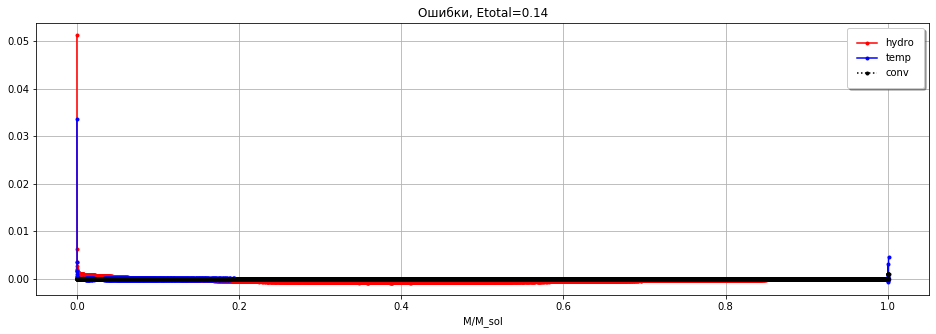

In [92]:
plt.figure(figsize=(16, 5))
ax = plt.axes()
m1 = m/s.M
plt.plot(m1[1:-1], ea[1:-1], marker='.', color='red', label='hydro')
plt.plot(m1[1:-1], eb[1:-1], marker='.', color='blue', label='temp')
plt.plot(m1[1:-1], c[1:-1]*.001, ':k', marker='.', label='conv')
# # plt.xlim(0.,0.01)
# plt.xlim(0.95,1.0)
# # plt.ylim(-0.01, 0.01)
plt.xlabel('M/M_sol')
plt.ylabel('')
plt.title('Ошибки, Etotal=%.2f' % etot)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

In [170]:
df = df0.copy()

In [171]:
m = df.Mass.values
r = df.Radius.values
t = df.Temperature.values
d = df.Density.values
l = df.Luminosity.values
x = df.Hydrogen.values
k = df.Opacity.values
c = df.Convection.values
p = df.Pressure.values
v = df.Velocity.values

In [172]:
NG = 60 
err = np.zeros(NG + 1)
x0 = df0.Hydrogen.values.copy()
x = x0*np.exp(-1e8*v)
d[0] = 3*m[1]/4/ph.pi/pow(r[1], 3)
#     t[0] = ????
l[0] = 0.
for i in range(1, dimM - 1):
    d[i] = 1/4/ph.pi/pow(r[i], 2)*(m[i+1] - m[i-1])/(r[i+1]-r[i-1])
#     l[i] = l[i-1] + (m[i] - m[i-1])*ph.Etot(0.5*(d[i] + d[i-1]), 0.5*(t[i] + t[i-1]), x[i], 1 - Z - x[i], Z)
    l[i] = l[i-1] + (m[i] - m[i-1])*ph.Etot(d[i], t[i], x[i], 1 - Z - x[i], Z)
for i in range(dimM):
    k[i] = ph.Opacity(d[i], t[i], x[i], 1 - Z - x[i], Z)
    p[i] = ph.Pressure(d[i], t[i], x[i], 1 - Z - x[i], Z)
# Теперь в df - начальное приближение для новой эпохи.

In [173]:
count = 0
etot = Error(df)
err[count] = etot
etot

40307.27499431137

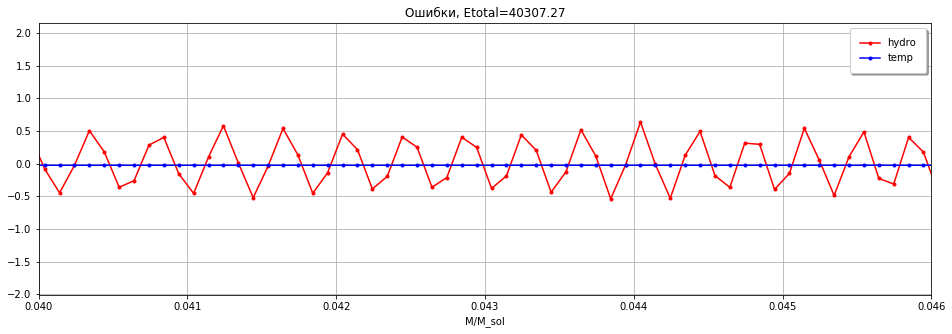

In [174]:
plt.figure(figsize=(16, 5))
ax = plt.axes()
m1 = m/s.M
plt.plot(m1, ea, marker='.', color='red', label='hydro')
plt.plot(m1, eb, marker='.', color='blue', label='temp')
# plt.plot(m1, c*.05, ':k', marker='.', label='conv')
# plt.xlim(0.995,1.002)
plt.xlim(0.04,0.046)
plt.ylim(-2.01, 2.15)
plt.xlabel('M/M_sol')
plt.ylabel('')
plt.title('Ошибки, Etotal=%.2f' % etot)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

In [175]:
%%time
"""
Цикл итераций. NG - число итераций, count - переменная цикла.
"""

count = 0
k0 = 0.0001

while count < 1: #NG:
    # Варьируем r & t в направлении уменьшения ошибки, получая следующую итерацию.
    for i in range(1, dimM - 1):
        r[i] = r[i]*(1 - k0*ea[i])
        t[i] = t[i]*(1 - k0*eb[i])
#     d[0] = 3*m[1]/4/ph.pi/pow(r[1], 3)
# #     t[0] = ????
#     l[0] = 0.
#     for i in range(1, dimM - 1):
#         d[i] = 1/4/ph.pi/pow(r[i], 2)*(m[i+1] - m[i-1])/(r[i+1]-r[i-1])
#         l[i] = l[i-1] + (m[i] - m[i-1])*ph.Etot(0.5*(d[i] + d[i-1]), 0.5*(t[i] + t[i-1]), x[i], 1 - Z - x[i], Z)
#     for i in range(dimM - 1):
#         k[i] = ph.Opacity(d[i], t[i], x[i], 1 - Z - x[i], Z)
#         p[i] = ph.Pressure(d[i], t[i], x[i], 1 - Z - x[i], Z)
#         v[i] = 4*ph.m_prot*ph.Etot(d1[i], t1[i], X, Y, Z)/X/ph.dEpp*ph.year
#         print('i=%d r=%.2f r1=%.2f t=%.1f t1=%.1f' % (i, r[i], r1[i], t[i], t1[i]))
    err0 = err[count]
    count += 1
    err1 = Error(df)
    
    err[count] = err1
    print('count=%d Error=%.2f Ratio=%.3f' % (count, err[count], 100*err0/err1 - 100.))
#     if err0 <= err1:
#         break

count=1 Error=42379.39 Ratio=-4.889
Wall time: 383 ms


In [155]:
df1 = pd.DataFrame({'Mass': m, 'Radius': r, 'Temperature': t, 'Density': d, 
          'Luminosity': l, 'Hydrogen': x, 'Opacity': k, 'Convection': c, 'Pressure': p, 'Velocity': v})
df1

,Mass,Radius,Temperature,Density,Luminosity,Hydrogen,Opacity,Convection,Pressure,Velocity
0,0.000000e+00,0.000000e+00,1.451000e+07,90.073860,0.000000e+00,0.723205,1.445415,0.0,1.794120e+17,1.208753e-10
1,1.992041e+29,8.086197e+08,1.448616e+07,89.853305,3.327251e+30,0.723300,1.448873,0.0,1.786787e+17,1.195617e-10
2,3.984082e+29,1.019092e+09,1.447218e+07,89.722614,6.633677e+30,0.723355,1.450894,0.0,1.782465e+17,1.187975e-10
3,5.976123e+29,1.166858e+09,1.446045e+07,89.612835,9.922761e+30,0.723402,1.452590,0.0,1.778842e+17,1.181611e-10
4,7.968163e+29,1.284576e+09,1.444999e+07,89.514752,1.319646e+31,0.723442,1.454104,0.0,1.775610e+17,1.175968e-10
...,...,...,...,...,...,...,...,...,...,...
9996,1.991244e+33,4.536990e+10,3.854278e+05,0.035663,3.526911e+33,0.732000,0.825068,1.0,1.886897e+12,2.183289e-26
9997,1.991443e+33,4.560445e+10,3.415529e+05,0.029744,3.526911e+33,0.732000,0.754712,1.0,1.394588e+12,5.057721e-27
9998,1.991642e+33,4.589195e+10,2.883817e+05,0.023070,3.526911e+33,0.732000,0.675243,1.0,9.132617e+11,6.525222e-28
9999,1.991842e+33,4.628649e+10,2.164797e+05,0.014997,3.526911e+33,0.732000,0.578994,1.0,4.456675e+11,2.029214e-29


In [156]:
epoch = 1
_ = df1.to_csv(line_terminator='\n')
filename = "Mass/4epoch%.02d.csv" % epoch
print(filename)
csv_file = open(filename, "wt")
n = csv_file.write(_)
csv_file.close()

Mass/4epoch01.csv


In [147]:
epoch = 0
df = load_model(epoch)
d = df['Density'].values
t = df['Temperature'].values
d

array([9.00738577e+01, 8.90411272e+01, 8.84305086e+01, ...,
       1.25189351e-01, 7.53021785e-02, 2.09797553e-05])

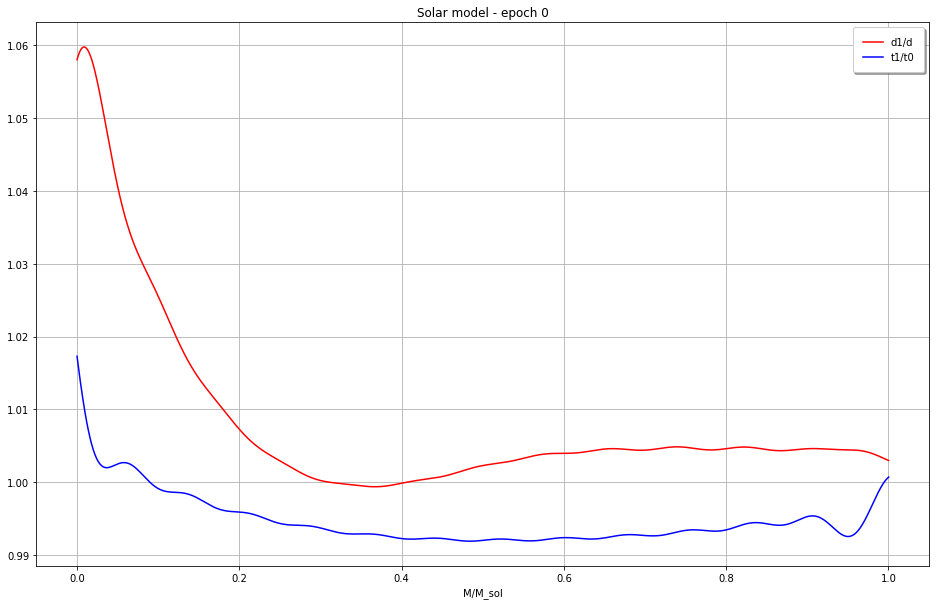

In [148]:
m1 = m/s.M
plt.figure(figsize=(16, 10))
ax = plt.axes()
# plt.plot(r1, c, color='black', label='Convection')
plt.plot(m1, d1/d, color='red', label='d1/d')
plt.plot(m1, t1/t, color='blue', label='t1/t0')
# plt.xlim(-0.1,0.1)
# plt.ylim(-0.1, 0.1)
plt.xlabel('M/M_sol')
plt.ylabel('')
plt.title('Solar model - epoch %d' % epoch)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

In [149]:
ea = np.zeros(dimM)
eb = np.zeros(dimM)
for i in range(1, dimM-1):
    ea[i] = 3*pow((da[i] - a[i])/6760886, 2)
    eb[i] = pow((db[i] - b[i])/0.000324, 2)
sa = ea.sum()
sb = eb.sum()
etot = (sa + sb)/0.09726621893099568

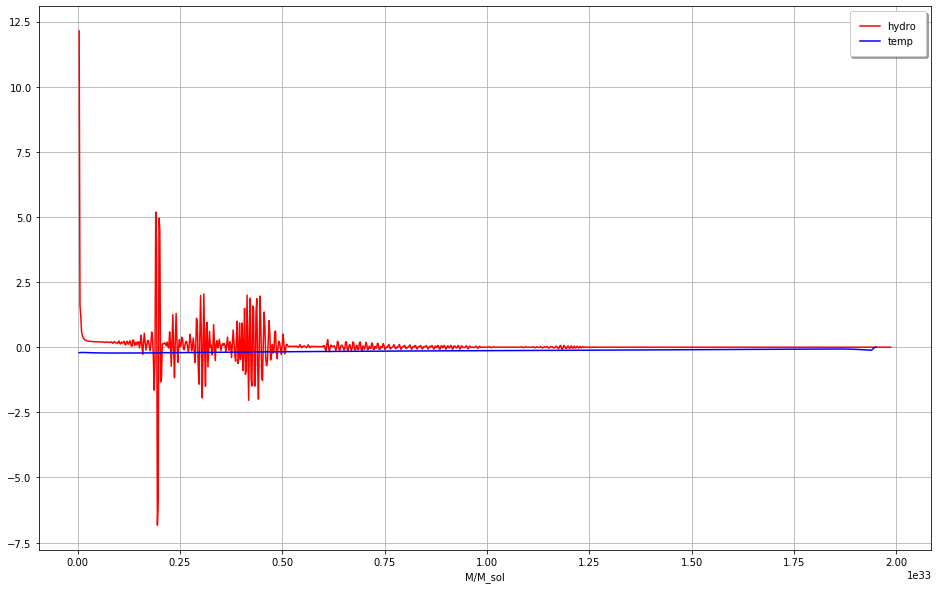

In [37]:
plt.figure(figsize=(16, 10))
ax = plt.axes()
# plt.plot(r1, c, color='black', label='Convection')
plt.plot(m[2:-2], ea[2:-2], color='red', label='hydro')
plt.plot(m[2:-20], eb[2:-20], color='blue', label='temp')
# plt.xlim(-0.1,0.1)
# plt.ylim(-0.1, 0.1)
plt.xlabel('M/M_sol')
plt.ylabel('')
# plt.title('Error %.2f' % etot)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);